# World & French sample

In [1]:
!dir '/efs/home/archive/prj_bdx/WIPR19DB/dta/'

cluster_labels.dta     ipf_invctry.dta	   isp_citation.dta
famid_apptname.csv     ipf_invgeo.dta	   isp_geo.dta
famid_invname_std.csv  ipf_main.dta	   isp_main.dta
htec_labels.dta        ipf_topcit.dta	   isp_scif.dta
ipf_apptinfo.dta       ipf_totcit.dta	   isp_topcit.dta
ipf_htec.dta	       isp_autcluster.dta  isp_totcit.dta
ipf_invcluster.dta     isp_autctry.dta	   member_states.dta


In [2]:
# dfmain = pd.read_stata('/efs/home/archive/prj_bdx/WIPR19DB/dta/ipf_main.dta')  
# dfmain.describe()

## source: 
archive/prj_bdx/WIPR19DB/dta/ipf_invgeo.dta

## boundaries:
- North: 51°05' N (Bray-Dunes)
- South: 42°20' N (Puig de Comanegra)
- East: 8°13' E (Lauterbourg)
- West: 4°47' W (Pointe de Corsen)

In [3]:
# FR limits
north = 51 + 5/60
south = 42 + 20/60
east = 8 + 13/60
west = -4 - 47/60

In [4]:
#
print(north, south, west, east)
print((north-south)*.1)
print((east-west)*.1)
buffer = 1.5 # >than both above
bndn = north +  buffer
bnds = south - buffer
bnde = east + buffer
bndw = west - buffer

51.083333333333336 42.333333333333336 -4.783333333333333 8.216666666666667
0.875
1.3


# Declarations

In [5]:
samplesize = 100000
r_km = 6378.137 # 6371 # multiplier to convert to km (from unit distance)
# 6356.752 km at the poles to 6378.137 km at equator


In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import haversine_distances
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors import BallTree
import math

# World

In [7]:
# Full dataset
df = pd.read_stata('/efs/home/archive/prj_bdx/WIPR19DB/dta/ipf_invgeo.dta')  

In [8]:
df.head()

,fam_id,invgeo_lat,invgeo_lng,invgeo_wgt
0,58,49.8647,8.66091,0.500000
1,58,49.9679,8.66340,0.500000
2,76,50.8146,3.05979,0.500000
3,76,50.9488,3.27389,0.500000
4,98,53.5773,9.96754,0.333333


In [9]:
df.count()

fam_id        13121589
invgeo_lat    13121589
invgeo_lng    13121589
invgeo_wgt    13121589
dtype: int64

In [10]:
# Sample dataset
df['wgt']=df['invgeo_wgt'].apply(np.ceil)
df_sample = df.sample(n=samplesize, random_state=1, weights=df['wgt'])
df_sample = df_sample.drop(columns=['fam_id', 'invgeo_wgt'])
df_sample.count()

invgeo_lat    100000
invgeo_lng    100000
wgt           100000
dtype: int64

In [11]:
df_sample.head()

,invgeo_lat,invgeo_lng,wgt
5471991,42.01450,-87.89920,1.0
9451801,34.40564,132.73969,1.0
1500,49.86280,8.55179,1.0
3967083,40.68500,-80.10710,1.0
1925670,51.81670,-1.23330,1.0


<AxesSubplot: xlabel='invgeo_lng', ylabel='invgeo_lat'>

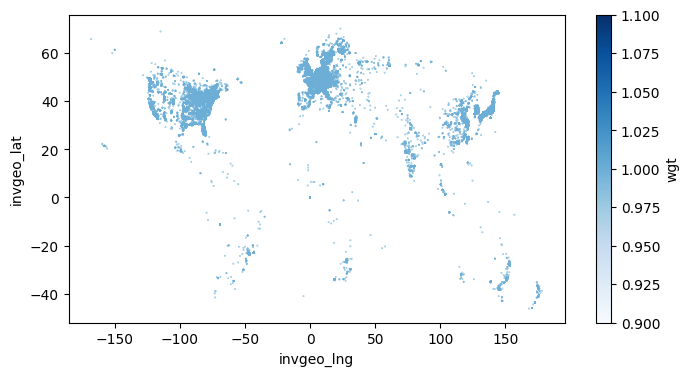

In [12]:
df_sample.plot(x="invgeo_lng", y="invgeo_lat", kind="scatter", s=.1, figsize=[8,4], c='wgt',colormap='Blues')

In [13]:
# convert coords to radians
df_sample['radlat']=np.deg2rad(df_sample['invgeo_lat'].values)
df_sample['radlng']=np.deg2rad(df_sample['invgeo_lng'].values)

In [14]:
# Calculates nearest neighbor for each point
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(df_sample[['radlat','radlng']])
distances, idx = nn.kneighbors(df_sample[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [15]:
# distance from radians to KMs
distances_km=distances*r_km

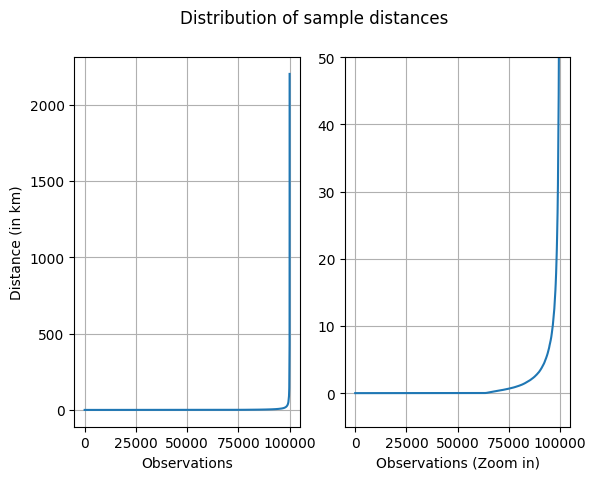

In [16]:
# plots NNs to look for "elbow"
plt.suptitle('Distribution of sample distances')
plt.subplot(1,2,1)
plt.plot(distances_km)
plt.grid(True)
plt.xlabel('Observations')
plt.ylabel('Distance (in km)')
plt.subplot(1,2,2)
plt.plot(distances_km)
plt.grid(True)
plt.ylim(ymax = 50, ymin=-5)
plt.xlabel('Observations (Zoom in)')
plt.show()

In [17]:
# count neighbors within given EPS
myeps = 15 # defined by above's chart
radius = myeps /r_km
tree = BallTree(df_sample[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=df_sample.wgt)
N=tree.query_radius(df_sample[['radlat','radlng']], r=radius, count_only=True)

In [18]:
df_sample['N']=N.tolist()
df_sample.head()

,invgeo_lat,invgeo_lng,wgt,radlat,radlng,N
5471991,42.01450,-87.89920,1.0,0.733291,-1.534130,220
9451801,34.40564,132.73969,1.0,0.600492,2.316745,14
1500,49.86280,8.55179,1.0,0.870270,0.149257,199
3967083,40.68500,-80.10710,1.0,0.710087,-1.398133,47
1925670,51.81670,-1.23330,1.0,0.904372,-0.021525,67


In [19]:
df_sample.describe()

,invgeo_lat,invgeo_lng,wgt,radlat,radlng,N
count,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000
mean,40.122387,13.140862,1.0,0.700268,0.229351,597.365220
std,11.804428,93.242775,0.0,0.206026,1.627393,1241.681109
min,-46.083300,-168.087010,1.0,-0.804305,-2.933672,1.000000
25%,35.537670,-76.950825,1.0,0.620249,-1.343045,35.000000
50%,40.000000,8.252800,1.0,0.698132,0.144039,132.000000
75%,48.016863,127.009000,1.0,0.838052,2.216725,437.000000
max,69.968700,178.018010,1.0,1.221184,3.107000,6165.000000


In [20]:
from statsmodels.stats.weightstats import DescrStatsW
wdf = DescrStatsW(df_sample.N, weights=df_sample.wgt, ddof=1) 
uwdf = DescrStatsW(df_sample.N,  ddof=1) 
print( wdf.mean, uwdf.mean )
print( wdf.std, uwdf.std )
print( wdf.quantile([0, 0.25,0.50,0.75, 1]), uwdf.quantile([0, 0.25,0.50,0.75, 1]) )

597.36522 597.36522
1241.6811090107299 1241.6811090107299
p
0.00       1
0.25      35
0.50     132
0.75     437
1.00    6165
dtype: int64 p
0.00       1
0.25      35
0.50     132
0.75     437
1.00    6165
dtype: int64


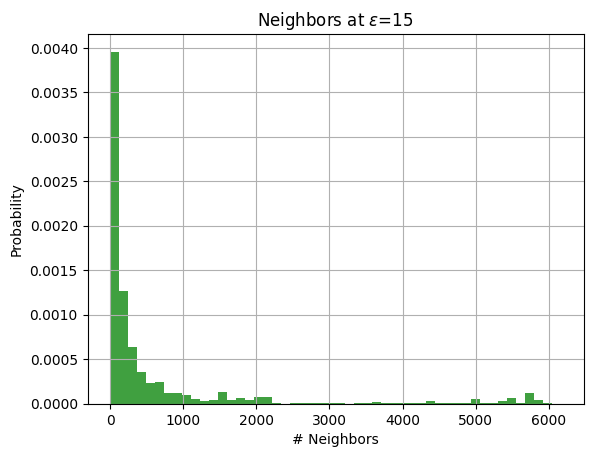

In [21]:
n, bins, patches = plt.hist(df_sample.N, 50, density=True, facecolor='g', alpha=0.75, weights=df_sample.wgt)
plt.xlabel('# Neighbors')
plt.ylabel('Probability')
plt.title('Neighbors at '+r'$\epsilon$='+str(myeps))
plt.grid(True)
plt.show()

In [22]:
# Number of weighted observations
nobswgt = df_sample.wgt.sum()
nobswgt

100000.0

In [23]:
# loop within percentiles
for i in range(1, 100, 1):
    print(i, "...", end = '')
    minpts = math.ceil(wdf.quantile([i/100]).values[0])
    np.percentile(N, i, axis=0)    
    db = DBSCAN(eps=myeps/r_km, min_samples=minpts, algorithm='ball_tree', metric='haversine').fit(df_sample[['radlat','radlng']], sample_weight=df_sample.wgt)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise = list(labels).count(-1)
    df_sample['labels']=labels.tolist()
    n_noise = df_sample[df_sample['labels']==-1].wgt.sum()
    noise_share = (n_noise/nobswgt)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(100-i))-1
    silhout=None # too slow
    # try: 
    #     silhout=metrics.silhouette_score(df_sample[['radlat','radlng']], labels, metric='haversine')
    # except:
    #     silhout=None
    curdata = pd.DataFrame({'pctile':[i],'neighbors':[minpts],'cluster_share':[cluster_share],'conc_coeff':[conc_coeff],
            'silhout':[silhout],'n_clusters':[n_clusters],'n_noise':[n_noise], 'noise_share':[noise_share]})
    if i==1:
        df_pctiles = curdata
    else:
        df_pctiles=pd.concat((df_pctiles, curdata), ignore_index=True, axis=0)
print( "Done!")
df_pctiles.head()

1 ...2 ...3 ...4 ...5 ...6 ...7 ...8 ...9 ...10 ...11 ...12 ...13 ...14 ...15 ...16 ...17 ...18 ...19 ...20 ...21 ...22 ...23 ...24 ...25 ...26 ...27 ...28 ...29 ...30 ...31 ...32 ...33 ...34 ...35 ...36 ...37 ...38 ...39 ...40 ...41 ...42 ...43 ...44 ...45 ...46 ...47 ...48 ...49 ...50 ...51 ...52 ...53 ...54 ...55 ...56 ...57 ...58 ...59 ...60 ...61 ...62 ...63 ...64 ...65 ...66 ...67 ...68 ...69 ...70 ...71 ...72 ...73 ...74 ...75 ...76 ...77 ...78 ...79 ...80 ...81 ...82 ...83 ...84 ...85 ...86 ...87 ...88 ...89 ...90 ...91 ...92 ...93 ...94 ...95 ...96 ...97 ...98 ...99 ...Done!


,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
0,1,1,100.000,0.010101,None,4127,0.0,0.000
1,2,1,100.000,0.020408,None,4127,0.0,0.000
2,3,2,97.621,0.006402,None,1748,2379.0,2.379
3,4,2,97.621,0.016885,None,1748,2379.0,2.379
4,5,3,96.413,0.014874,None,1144,3587.0,3.587


In [24]:
df_pctiles.tail()

,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
94,95,4311,7.533002,0.506600,None,1,92467.0,92.466998
95,96,4995,7.353002,0.838250,None,1,92647.0,92.646998
96,97,5463,7.279003,1.426334,None,1,92721.0,92.720997
97,98,5686,7.248002,2.624001,None,1,92752.0,92.751998
98,99,5724,6.971002,5.971002,None,1,93029.0,93.028998


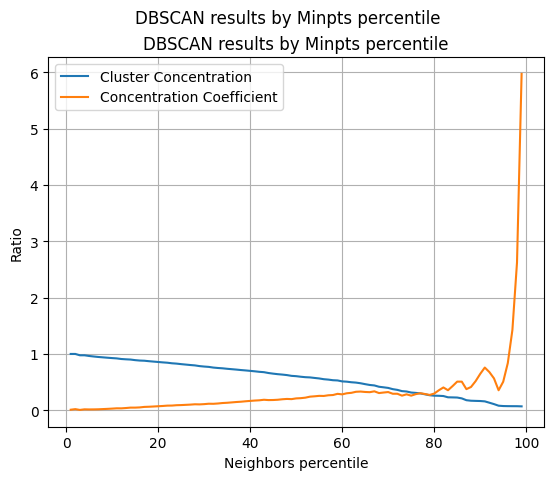

In [25]:
# plot lines
dfplt=df_pctiles[df_pctiles['n_clusters']>0]
plt.figure(figsize=(12, 4))
plt.suptitle('DBSCAN results by Minpts percentile')
plt.subplot(1,3,1)
plt.plot(dfplt['pctile'], dfplt['cluster_share'], label = "Cluster Concentration")
plt.plot(dfplt['pctile'], 100- dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Concentration (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(1,3,2)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Ratio')
plt.legend(loc='upper left')
plt.grid(True)
plt.subplot(1,3,3)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile (Zoom in)')
plt.ylabel('Ratio')
plt.ylim(-0.05, 1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# France

In [26]:
dffr = df[(df['invgeo_lat']<=bndn) & (df['invgeo_lat']>=bnds) & (df['invgeo_lng']>=bndw) & (df['invgeo_lng']<=bnde)]

In [27]:
dffr.count()

fam_id        2488820
invgeo_lat    2488820
invgeo_lng    2488820
invgeo_wgt    2488820
wgt           2488820
dtype: int64

In [28]:
dffr.describe()

,fam_id,invgeo_lat,invgeo_lng,invgeo_wgt,wgt
count,2.488820e+06,2.488820e+06,2.488820e+06,2.488820e+06,2488820.0
mean,2.746694e+08,4.924913e+01,5.560158e+00,5.338703e-01,1.0
std,3.512400e+08,2.335759e+00,3.515844e+00,3.231454e-01,0.0
min,5.800000e+01,4.083340e+01,-6.283020e+00,8.695652e-03,1.0
25%,1.572383e+07,4.781820e+01,2.482280e+00,2.500000e-01,1.0
50%,2.445503e+07,4.946780e+01,6.884500e+00,5.000000e-01,1.0
75%,4.383793e+08,5.121670e+01,8.484850e+00,1.000000e+00,1.0
max,9.080338e+08,5.258330e+01,9.716650e+00,1.000000e+00,1.0


In [29]:
# Sample dataset
# df['wgt']=df['invgeo_wgt'].apply(np.ceil)
df_sample = dffr.sample(n=samplesize, random_state=1, weights=df['wgt'])
df_sample = df_sample.drop(columns=['fam_id', 'invgeo_wgt'])
df_sample.count()

invgeo_lat    100000
invgeo_lng    100000
wgt           100000
dtype: int64

In [30]:
df_sample.head()

,invgeo_lat,invgeo_lng,wgt
1731083,48.80520,2.12196,1.0
7327520,51.62358,-1.29485,1.0
458,45.24640,5.72737,1.0
1371180,48.75650,2.30622,1.0
689232,50.68950,7.16745,1.0


<AxesSubplot: xlabel='invgeo_lng', ylabel='invgeo_lat'>

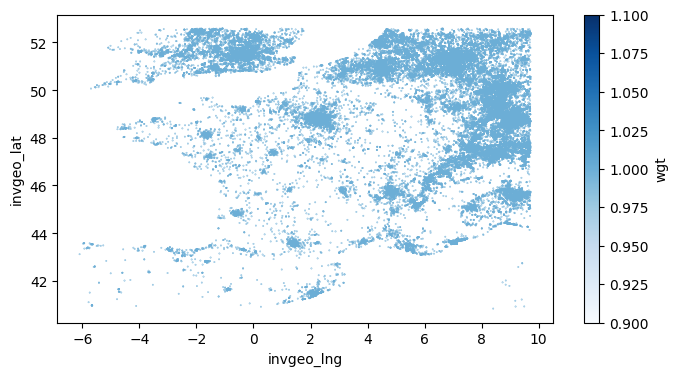

In [31]:
df_sample.plot(x="invgeo_lng", y="invgeo_lat", kind="scatter", s=.1, figsize=[8,4], c='wgt',colormap='Blues')

In [32]:
# convert coords to radians
df_sample['radlat']=np.deg2rad(df_sample['invgeo_lat'].values)
df_sample['radlng']=np.deg2rad(df_sample['invgeo_lng'].values)

In [33]:
# Calculates nearest neighbor for each point
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(df_sample[['radlat','radlng']])
distances, idx = nn.kneighbors(df_sample[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [34]:
# distance from radians to KMs
distances_km=distances*r_km

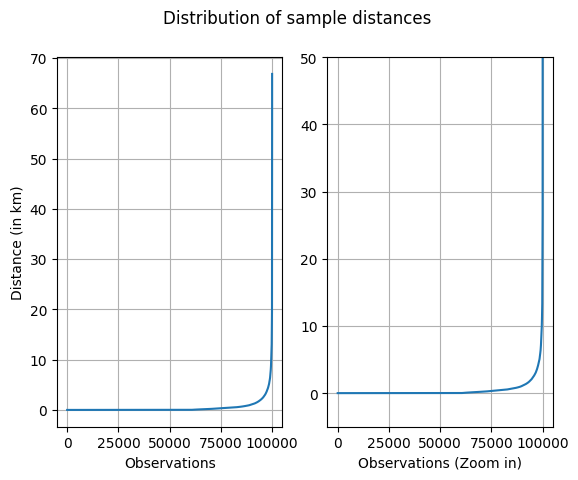

In [35]:
# plots NNs to look for "elbow"
plt.suptitle('Distribution of sample distances')
plt.subplot(1,2,1)
plt.plot(distances_km)
plt.grid(True)
plt.xlabel('Observations')
plt.ylabel('Distance (in km)')
plt.subplot(1,2,2)
plt.plot(distances_km)
plt.grid(True)
plt.ylim(ymax = 50, ymin=-5)
plt.xlabel('Observations (Zoom in)')
plt.show()

In [36]:
# count neighbors within given EPS
myeps = 15 # defined by above's chart
radius = myeps /r_km
tree = BallTree(df_sample[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=df_sample.wgt)
N=tree.query_radius(df_sample[['radlat','radlng']], r=radius, count_only=True)

In [37]:
df_sample['N']=N.tolist()
df_sample.head()

,invgeo_lat,invgeo_lng,wgt,radlat,radlng,N
1731083,48.80520,2.12196,1.0,0.851811,0.037035,2953
7327520,51.62358,-1.29485,1.0,0.901001,-0.022599,416
458,45.24640,5.72737,1.0,0.789699,0.099961,795
1371180,48.75650,2.30622,1.0,0.850961,0.040251,4335
689232,50.68950,7.16745,1.0,0.884699,0.125096,503


In [38]:
df_sample.describe()

,invgeo_lat,invgeo_lng,wgt,radlat,radlng,N
count,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.00000
mean,49.242567,5.578677,1.0,0.859445,0.097366,911.20526
std,2.330834,3.513712,0.0,0.040681,0.061326,1101.03924
min,40.834100,-6.099700,1.0,0.712689,-0.106460,1.00000
25%,47.817575,2.508013,1.0,0.834574,0.043773,158.00000
50%,49.459800,6.900600,1.0,0.863236,0.120438,469.00000
75%,51.215750,8.491018,1.0,0.893883,0.148196,1291.00000
max,52.583300,9.716650,1.0,0.917752,0.169588,5099.00000


In [39]:
from statsmodels.stats.weightstats import DescrStatsW
wdf = DescrStatsW(df_sample.N, weights=df_sample.wgt, ddof=1) 
uwdf = DescrStatsW(df_sample.N,  ddof=1) 
print( wdf.mean, uwdf.mean )
print( wdf.std, uwdf.std )
print( wdf.quantile([0, 0.25,0.50,0.75, 1]), uwdf.quantile([0, 0.25,0.50,0.75, 1]) )

911.20526 911.20526
1101.0392402555044 1101.0392402555044
p
0.00       1
0.25     158
0.50     469
0.75    1291
1.00    5099
dtype: int64 p
0.00       1
0.25     158
0.50     469
0.75    1291
1.00    5099
dtype: int64


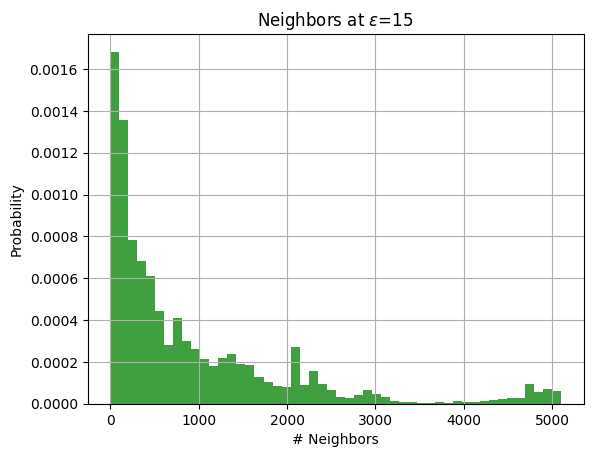

In [40]:
n, bins, patches = plt.hist(df_sample.N, 50, density=True, facecolor='g', alpha=0.75, weights=df_sample.wgt)
plt.xlabel('# Neighbors')
plt.ylabel('Probability')
plt.title('Neighbors at '+r'$\epsilon$='+str(myeps))
plt.grid(True)
plt.show()

In [41]:
# Number of weighted observations
nobswgt = df_sample.wgt.sum()
nobswgt

100000.0

In [42]:
# loop within percentiles
for i in range(1, 100, 1):
    print(i, "...", end = '')
    minpts = math.ceil(wdf.quantile([i/100]).values[0])
    np.percentile(N, i, axis=0)    
    db = DBSCAN(eps=myeps/r_km, min_samples=minpts, algorithm='ball_tree', metric='haversine').fit(df_sample[['radlat','radlng']], sample_weight=df_sample.wgt)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise = list(labels).count(-1)
    df_sample['labels']=labels.tolist()
    n_noise = df_sample[df_sample['labels']==-1].wgt.sum()
    noise_share = (n_noise/nobswgt)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(100-i))-1
    silhout=None # too slow
    # try: 
    #     silhout=metrics.silhouette_score(df_sample[['radlat','radlng']], labels, metric='haversine')
    # except:
    #     silhout=None
    curdata = pd.DataFrame({'pctile':[i],'neighbors':[minpts],'cluster_share':[cluster_share],'conc_coeff':[conc_coeff],
            'silhout':[silhout],'n_clusters':[n_clusters],'n_noise':[n_noise], 'noise_share':[noise_share]})
    if i==1:
        df_pctiles = curdata
    else:
        df_pctiles=pd.concat((df_pctiles, curdata), ignore_index=True, axis=0)
print( "Done!")
df_pctiles.head()

1 ...2 ...3 ...4 ...5 ...6 ...7 ...8 ...9 ...10 ...11 ...12 ...13 ...14 ...15 ...16 ...17 ...18 ...19 ...20 ...21 ...22 ...23 ...24 ...25 ...26 ...27 ...28 ...29 ...30 ...31 ...32 ...33 ...34 ...35 ...36 ...37 ...38 ...39 ...40 ...41 ...42 ...43 ...44 ...45 ...46 ...47 ...48 ...49 ...50 ...51 ...52 ...53 ...54 ...55 ...56 ...57 ...58 ...59 ...60 ...61 ...62 ...63 ...64 ...65 ...66 ...67 ...68 ...69 ...70 ...71 ...72 ...73 ...74 ...75 ...76 ...77 ...78 ...79 ...80 ...81 ...82 ...83 ...84 ...85 ...86 ...87 ...88 ...89 ...90 ...91 ...92 ...93 ...94 ...95 ...96 ...97 ...98 ...99 ...Done!


,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
0,1,5,99.558,0.005636,None,111,442.0,0.442
1,2,10,98.877,0.008949,None,80,1123.0,1.123
2,3,15,98.399,0.014423,None,81,1601.0,1.601
3,4,20,97.744,0.018167,None,61,2256.0,2.256
4,5,25,97.234,0.023516,None,58,2766.0,2.766


In [43]:
df_pctiles.tail()

,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
94,95,3073,11.170000,1.234000,None,2,88830.0,88.830000
95,96,4114,6.603003,0.650751,None,1,93397.0,93.396997
96,97,4660,6.377000,1.125667,None,1,93623.0,93.623000
97,98,4793,6.283998,2.141999,None,1,93716.0,93.716002
98,99,4948,5.993003,4.993003,None,1,94007.0,94.006997


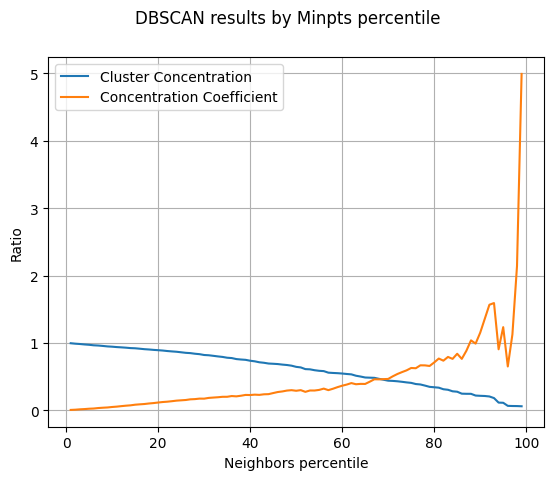

In [44]:
# plot lines
dfplt=df_pctiles[df_pctiles['n_clusters']>0]
plt.figure(figsize=(12, 4))
plt.suptitle('DBSCAN results by Minpts percentile')
plt.subplot(1,3,1)
plt.plot(dfplt['pctile'], dfplt['cluster_share'], label = "Cluster Concentration")
plt.plot(dfplt['pctile'], 100- dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Concentration (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(1,3,2)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Ratio')
plt.legend(loc='upper left')
plt.grid(True)
plt.subplot(1,3,3)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile (Zoom in)')
plt.ylabel('Ratio')
plt.ylim(-0.05, 1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# World (Pubs)

In [45]:
df = pd.read_stata('/efs/home/archive/prj_bdx/WIPR19DB/dta/isp_geo.dta')  

In [46]:
df.head()

,isp_id,lat,lng,autgeo_q,autgeo_wgt
0,1,35.201698,-89.971497,1,1.000000
1,3,38.951698,-92.334099,2,1.000000
2,5,38.986301,-3.929100,2,1.000000
3,6,34.053101,-118.380600,1,0.166667
4,6,34.147800,-118.144501,1,0.166667


In [47]:
df.count()

isp_id        44745875
lat           44745875
lng           44745875
autgeo_q      44745875
autgeo_wgt    44745875
dtype: int64

In [48]:
# Sample dataset
df['wgt']=df['autgeo_wgt'].apply(np.ceil)
df_sample = df.sample(n=samplesize, random_state=1, weights=df['wgt'])
df_sample = df_sample.drop(columns=['isp_id', 'autgeo_wgt','autgeo_q'])
df_sample.count()

lat    100000
lng    100000
wgt    100000
dtype: int64

In [49]:
df_sample.head()

,lat,lng,wgt
18660014,41.508400,-81.607597,1.0
32231549,50.454659,30.523800,1.0
5117,44.442101,-73.082497,1.0
13528135,35.539200,139.747406,1.0
6566720,-19.856680,-43.957001,1.0


<AxesSubplot: xlabel='lng', ylabel='lat'>

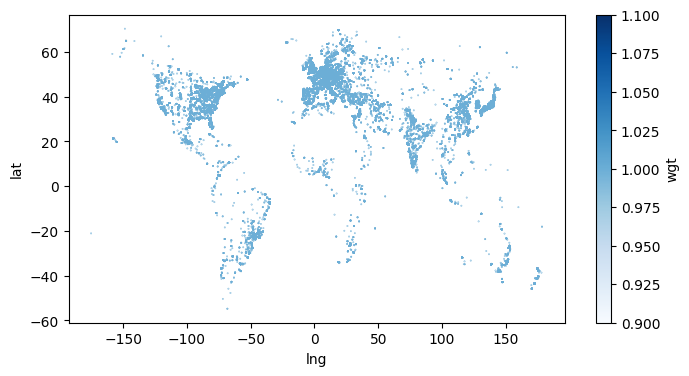

In [50]:
df_sample.plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], c='wgt',colormap='Blues')

In [51]:
# convert coords to radians
df_sample['radlat']=np.deg2rad(df_sample['lat'].values)
df_sample['radlng']=np.deg2rad(df_sample['lng'].values)

In [52]:
# Calculates nearest neighbor for each point
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(df_sample[['radlat','radlng']])
distances, idx = nn.kneighbors(df_sample[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [53]:
# distance from radians to KMs
distances_km=distances*r_km

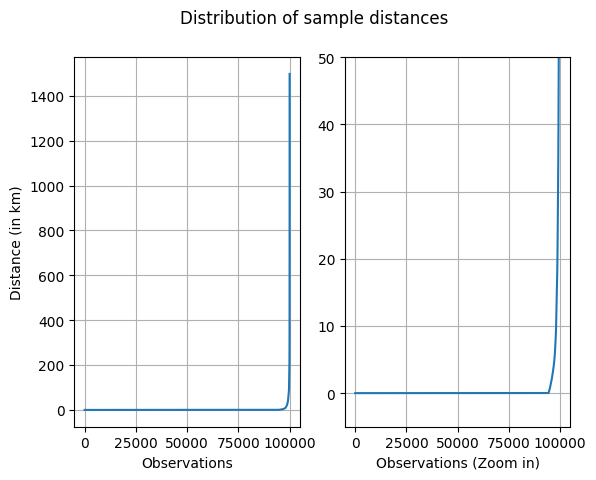

In [54]:
# plots NNs to look for "elbow"
plt.suptitle('Distribution of sample distances')
plt.subplot(1,2,1)
plt.plot(distances_km)
plt.grid(True)
plt.xlabel('Observations')
plt.ylabel('Distance (in km)')
plt.subplot(1,2,2)
plt.plot(distances_km)
plt.grid(True)
plt.ylim(ymax = 50, ymin=-5)
plt.xlabel('Observations (Zoom in)')
plt.show()

In [55]:
# count neighbors within given EPS
myeps = 15 # defined by above's chart
radius = myeps /r_km
tree = BallTree(df_sample[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=df_sample.wgt)
N=tree.query_radius(df_sample[['radlat','radlng']], r=radius, count_only=True)

In [56]:
df_sample['N']=N.tolist()
df_sample.head()

,lat,lng,wgt,radlat,radlng,N
18660014,41.508400,-81.607597,1.0,0.724458,-1.424321,186
32231549,50.454659,30.523800,1.0,0.880600,0.532741,108
5117,44.442101,-73.082497,1.0,0.775661,-1.275530,32
13528135,35.539200,139.747406,1.0,0.620276,2.439052,315
6566720,-19.856680,-43.957001,1.0,-0.346564,-0.767194,80


In [57]:
df_sample.describe()

,lat,lng,wgt,radlat,radlng,N
count,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000
mean,36.642303,7.630202,1.0,0.639529,0.133172,296.888140
std,19.509384,81.527603,0.0,0.340503,1.422925,385.139557
min,-54.799999,-175.201797,1.0,-0.956440,-3.057848,1.000000
25%,34.063702,-74.135693,1.0,0.594524,-1.293912,53.000000
50%,40.416500,6.632800,1.0,0.705401,0.115764,155.000000
75%,48.150201,76.984482,1.0,0.840380,1.343633,368.000000
max,70.292198,178.441483,1.0,1.226830,3.114391,1812.000000


In [58]:
from statsmodels.stats.weightstats import DescrStatsW
wdf = DescrStatsW(df_sample.N, weights=df_sample.wgt, ddof=1) 
uwdf = DescrStatsW(df_sample.N,  ddof=1) 
print( wdf.mean, uwdf.mean )
print( wdf.std, uwdf.std )
print( wdf.quantile([0, 0.25,0.50,0.75, 1]), uwdf.quantile([0, 0.25,0.50,0.75, 1]) )

296.88814 296.88814
385.1395570856424 385.1395570856424
p
0.00       1
0.25      53
0.50     155
0.75     368
1.00    1812
dtype: int64 p
0.00       1
0.25      53
0.50     155
0.75     368
1.00    1812
dtype: int64


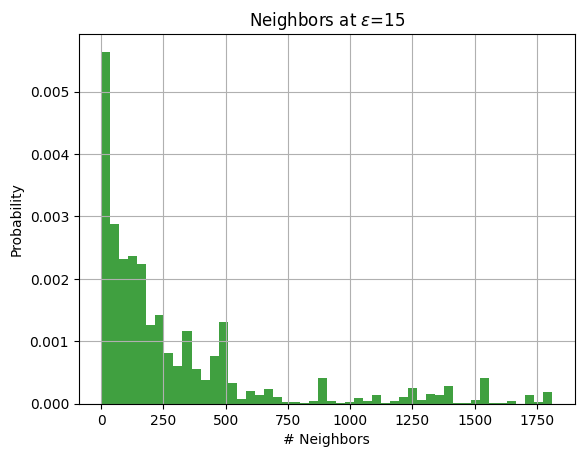

In [59]:
n, bins, patches = plt.hist(df_sample.N, 50, density=True, facecolor='g', alpha=0.75, weights=df_sample.wgt)
plt.xlabel('# Neighbors')
plt.ylabel('Probability')
plt.title('Neighbors at '+r'$\epsilon$='+str(myeps))
plt.grid(True)
plt.show()

In [60]:
# Number of weighted observations
nobswgt = df_sample.wgt.sum()
nobswgt

100000.0

In [61]:
# loop within percentiles
for i in range(1, 100, 1):
    print(i, "...", end = '')
    minpts = math.ceil(wdf.quantile([i/100]).values[0])
    np.percentile(N, i, axis=0)    
    db = DBSCAN(eps=myeps/r_km, min_samples=minpts, algorithm='ball_tree', metric='haversine').fit(df_sample[['radlat','radlng']], sample_weight=df_sample.wgt)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise = list(labels).count(-1)
    df_sample['labels']=labels.tolist()
    n_noise = df_sample[df_sample['labels']==-1].wgt.sum()
    noise_share = (n_noise/nobswgt)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(100-i))-1
    silhout=None # too slow
    # try: 
    #     silhout=metrics.silhouette_score(df_sample[['radlat','radlng']], labels, metric='haversine')
    # except:
    #     silhout=None
    curdata = pd.DataFrame({'pctile':[i],'neighbors':[minpts],'cluster_share':[cluster_share],'conc_coeff':[conc_coeff],
            'silhout':[silhout],'n_clusters':[n_clusters],'n_noise':[n_noise], 'noise_share':[noise_share]})
    if i==1:
        df_pctiles = curdata
    else:
        df_pctiles=pd.concat((df_pctiles, curdata), ignore_index=True, axis=0)
print( "Done!")
df_pctiles.head()

1 ...2 ...3 ...4 ...5 ...6 ...7 ...8 ...9 ...10 ...11 ...12 ...13 ...14 ...15 ...16 ...17 ...18 ...19 ...20 ...21 ...22 ...23 ...24 ...25 ...26 ...27 ...28 ...29 ...30 ...31 ...32 ...33 ...34 ...35 ...36 ...37 ...38 ...39 ...40 ...41 ...42 ...43 ...44 ...45 ...46 ...47 ...48 ...49 ...50 ...51 ...52 ...53 ...54 ...55 ...56 ...57 ...58 ...59 ...60 ...61 ...62 ...63 ...64 ...65 ...66 ...67 ...68 ...69 ...70 ...71 ...72 ...73 ...74 ...75 ...76 ...77 ...78 ...79 ...80 ...81 ...82 ...83 ...84 ...85 ...86 ...87 ...88 ...89 ...90 ...91 ...92 ...93 ...94 ...95 ...96 ...97 ...98 ...99 ...Done!


,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
0,1,1,100.000,0.010101,None,3970,0.0,0.000
1,2,2,98.438,0.004469,None,2408,1562.0,1.562
2,3,3,97.336,0.003464,None,1857,2664.0,2.664
3,4,4,96.518,0.005396,None,1587,3482.0,3.482
4,5,5,95.769,0.008095,None,1408,4231.0,4.231


In [62]:
df_pctiles.tail()

,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
94,95,1317,7.963002,0.592600,None,5,92037.0,92.036998
95,96,1381,6.386000,0.596500,None,4,93614.0,93.614000
96,97,1524,3.416002,0.138667,None,2,96584.0,96.583998
97,98,1548,3.416002,0.708001,None,2,96584.0,96.583998
98,99,1734,1.832998,0.832998,None,1,98167.0,98.167002


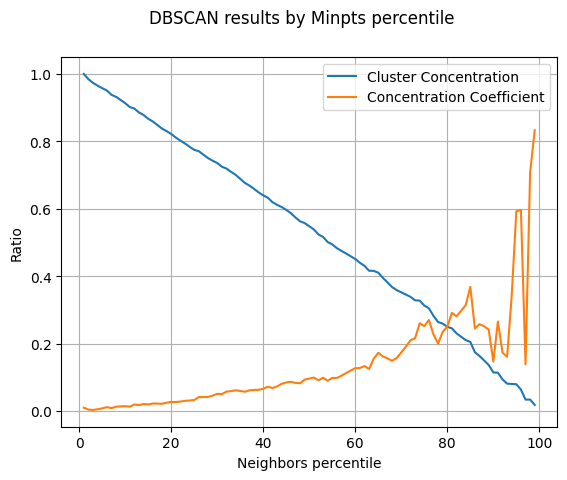

In [63]:
# plot lines
dfplt=df_pctiles[df_pctiles['n_clusters']>0]
plt.figure(figsize=(12, 4))
plt.suptitle('DBSCAN results by Minpts percentile')
plt.subplot(1,3,1)
plt.plot(dfplt['pctile'], dfplt['cluster_share'], label = "Cluster Concentration")
plt.plot(dfplt['pctile'], 100- dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Concentration (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(1,3,2)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Ratio')
plt.legend(loc='upper left')
plt.grid(True)
plt.subplot(1,3,3)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile (Zoom in)')
plt.ylabel('Ratio')
plt.ylim(-0.05, 1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# France (Pubs)

In [64]:
dffr = df[(df['lat']<=bndn) & (df['lat']>=bnds) & (df['lng']>=bndw) & (df['lng']<=bnde)]

In [65]:
dffr.count()

isp_id        7442817
lat           7442817
lng           7442817
autgeo_q      7442817
autgeo_wgt    7442817
wgt           7442817
dtype: int64

In [66]:
dffr.describe()

,isp_id,lat,lng,autgeo_q,autgeo_wgt,wgt
count,7.442817e+06,7.442817e+06,7.442817e+06,7.442817e+06,7.442817e+06,7442817.0
mean,3.623630e+07,4.884679e+01,3.698631e+00,1.228908e+00,4.603961e-01,1.0
std,1.297574e+07,3.099813e+00,3.732520e+00,6.203125e-01,3.165461e-01,0.0
min,1.100000e+01,4.083375e+01,-6.260200e+00,1.000000e+00,4.535147e-04,1.0
25%,2.788023e+07,4.694760e+01,1.115800e-01,1.000000e+00,2.000000e-01,1.0
50%,3.687653e+07,4.941690e+01,4.359620e+00,1.000000e+00,3.333333e-01,1.0
75%,4.670418e+07,5.149832e+01,6.989690e+00,1.000000e+00,6.000000e-01,1.0
max,5.589954e+07,5.258332e+01,9.715300e+00,5.400000e+01,1.000000e+00,1.0


In [67]:
# Sample dataset
# df['wgt']=df['autgeo_wgt'].apply(np.ceil)
df_sample = dffr.sample(n=samplesize, random_state=1, weights=df['wgt'])
df_sample = df_sample.drop(columns=['isp_id', 'autgeo_wgt','autgeo_q'])
df_sample.count()

lat    100000
lng    100000
wgt    100000
dtype: int64

In [68]:
df_sample.head()

,lat,lng,wgt
19808151,48.536900,9.05360,1.0
32350005,51.713600,8.75540,1.0
4960,52.259171,5.60694,1.0
14213141,50.879601,4.70090,1.0
6759852,50.143299,8.57110,1.0


<AxesSubplot: xlabel='lng', ylabel='lat'>

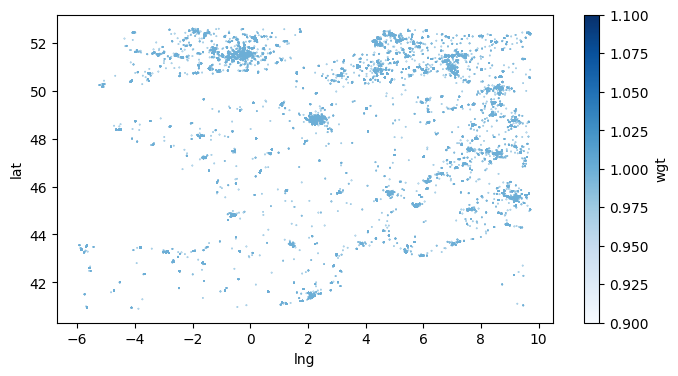

In [69]:
df_sample.plot(x="lng", y="lat", kind="scatter", s=.1, figsize=[8,4], c='wgt',colormap='Blues')

In [70]:
# convert coords to radians
df_sample['radlat']=np.deg2rad(df_sample['lat'].values)
df_sample['radlng']=np.deg2rad(df_sample['lng'].values)

In [71]:
# Calculates nearest neighbor for each point
nn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree', metric='haversine').fit(df_sample[['radlat','radlng']])
distances, idx = nn.kneighbors(df_sample[['radlat','radlng']])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [72]:
# distance from radians to KMs
distances_km=distances*r_km

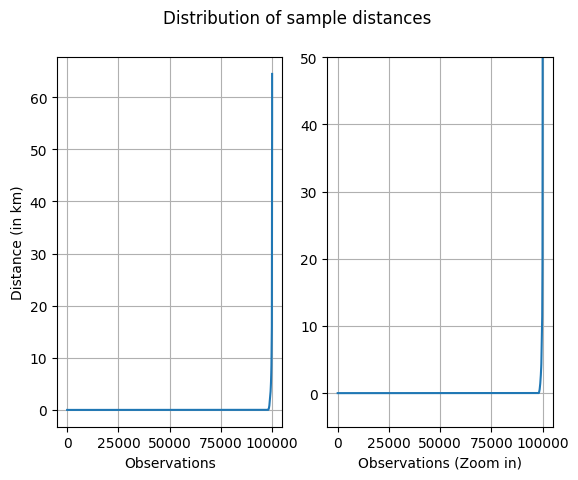

In [73]:
# plots NNs to look for "elbow"
plt.suptitle('Distribution of sample distances')
plt.subplot(1,2,1)
plt.plot(distances_km)
plt.grid(True)
plt.xlabel('Observations')
plt.ylabel('Distance (in km)')
plt.subplot(1,2,2)
plt.plot(distances_km)
plt.grid(True)
plt.ylim(ymax = 30, ymin=-5)
plt.xlabel('Observations (Zoom in)')
plt.show()

In [74]:
# count neighbors within given EPS
myeps = 15 # defined by above's chart
radius = myeps /r_km
tree = BallTree(df_sample[['radlat','radlng']], leaf_size=10, metric='haversine', sample_weight=df_sample.wgt)
N=tree.query_radius(df_sample[['radlat','radlng']], r=radius, count_only=True)

In [75]:
df_sample['N']=N.tolist()
df_sample.head()

,lat,lng,wgt,radlat,radlng,N
19808151,48.536900,9.05360,1.0,0.847129,0.158015,820
32350005,51.713600,8.75540,1.0,0.902573,0.152811,75
4960,52.259171,5.60694,1.0,0.912095,0.097860,50
14213141,50.879601,4.70090,1.0,0.888017,0.082046,1196
6759852,50.143299,8.57110,1.0,0.875166,0.149594,950


In [76]:
df_sample.describe()

,lat,lng,wgt,radlat,radlng,N
count,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000
mean,48.858364,3.701403,1.0,0.852739,0.064602,2218.332520
std,3.094496,3.720077,0.0,0.054009,0.064928,2689.024735
min,40.904099,-5.924800,1.0,0.713911,-0.103407,1.000000
25%,46.948101,0.116180,1.0,0.819399,0.002028,528.000000
50%,49.416901,4.355560,1.0,0.862488,0.076019,1041.000000
75%,51.498322,6.989690,1.0,0.898815,0.121993,2370.000000
max,52.582329,9.715300,1.0,0.917735,0.169564,9402.000000


In [77]:
from statsmodels.stats.weightstats import DescrStatsW
wdf = DescrStatsW(df_sample.N, weights=df_sample.wgt, ddof=1) 
uwdf = DescrStatsW(df_sample.N,  ddof=1) 
print( wdf.mean, uwdf.mean )
print( wdf.std, uwdf.std )
print( wdf.quantile([0, 0.25,0.50,0.75, 1]), uwdf.quantile([0, 0.25,0.50,0.75, 1]) )

2218.33252 2218.33252
2689.024734852897 2689.024734852897
p
0.00       1
0.25     528
0.50    1041
0.75    2370
1.00    9402
dtype: int64 p
0.00       1
0.25     528
0.50    1041
0.75    2370
1.00    9402
dtype: int64


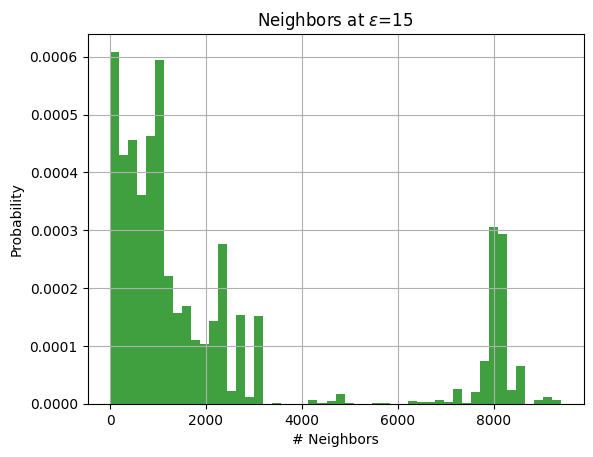

In [78]:
n, bins, patches = plt.hist(df_sample.N, 50, density=True, facecolor='g', alpha=0.75, weights=df_sample.wgt)
plt.xlabel('# Neighbors')
plt.ylabel('Probability')
plt.title('Neighbors at '+r'$\epsilon$='+str(myeps))
plt.grid(True)
plt.show()

In [79]:
# Number of weighted observations
nobswgt = df_sample.wgt.sum()
nobswgt

100000.0

In [80]:
# loop within percentiles
for i in range(1, 100, 1):
    print(i, "...", end = '')
    minpts = math.ceil(wdf.quantile([i/100]).values[0])
    np.percentile(N, i, axis=0)    
    db = DBSCAN(eps=myeps/r_km, min_samples=minpts, algorithm='ball_tree', metric='haversine').fit(df_sample[['radlat','radlng']], sample_weight=df_sample.wgt)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise = list(labels).count(-1)
    df_sample['labels']=labels.tolist()
    n_noise = df_sample[df_sample['labels']==-1].wgt.sum()
    noise_share = (n_noise/nobswgt)*100
    cluster_share = 100-noise_share
    conc_coeff = (cluster_share/(100-i))-1
    silhout=None # too slow
    # try: 
    #     silhout=metrics.silhouette_score(df_sample[['radlat','radlng']], labels, metric='haversine')
    # except:
    #     silhout=None
    curdata = pd.DataFrame({'pctile':[i],'neighbors':[minpts],'cluster_share':[cluster_share],'conc_coeff':[conc_coeff],
            'silhout':[silhout],'n_clusters':[n_clusters],'n_noise':[n_noise], 'noise_share':[noise_share]})
    if i==1:
        df_pctiles = curdata
    else:
        df_pctiles=pd.concat((df_pctiles, curdata), ignore_index=True, axis=0)
print( "Done!")
df_pctiles.head()

1 ...2 ...3 ...4 ...5 ...6 ...7 ...8 ...9 ...10 ...11 ...12 ...13 ...14 ...15 ...16 ...17 ...18 ...19 ...20 ...21 ...22 ...23 ...24 ...25 ...26 ...27 ...28 ...29 ...30 ...31 ...32 ...33 ...34 ...35 ...36 ...37 ...38 ...39 ...40 ...41 ...42 ...43 ...44 ...45 ...46 ...47 ...48 ...49 ...50 ...51 ...52 ...53 ...54 ...55 ...56 ...57 ...58 ...59 ...60 ...61 ...62 ...63 ...64 ...65 ...66 ...67 ...68 ...69 ...70 ...71 ...72 ...73 ...74 ...75 ...76 ...77 ...78 ...79 ...80 ...81 ...82 ...83 ...84 ...85 ...86 ...87 ...88 ...89 ...90 ...91 ...92 ...93 ...94 ...95 ...96 ...97 ...98 ...99 ...Done!


,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
0,1,9,99.214,0.002162,None,181,786.0,0.786
1,2,20,98.505,0.005153,None,139,1495.0,1.495
2,3,33,97.857,0.008835,None,127,2143.0,2.143
3,4,48,97.235,0.012865,None,117,2765.0,2.765
4,5,60,96.497,0.015758,None,109,3503.0,3.503


In [81]:
df_pctiles.tail()

,pctile,neighbors,cluster_share,conc_coeff,silhout,n_clusters,n_noise,noise_share
94,95,8100,18.504000,2.700800,None,2,81496.0,81.496000
95,96,8100,18.504000,3.626000,None,2,81496.0,81.496000
96,97,8115,18.500000,5.166667,None,2,81500.0,81.500000
97,98,8312,10.347003,4.173501,None,1,89653.0,89.652997
98,99,8610,10.176998,9.176998,None,1,89823.0,89.823002


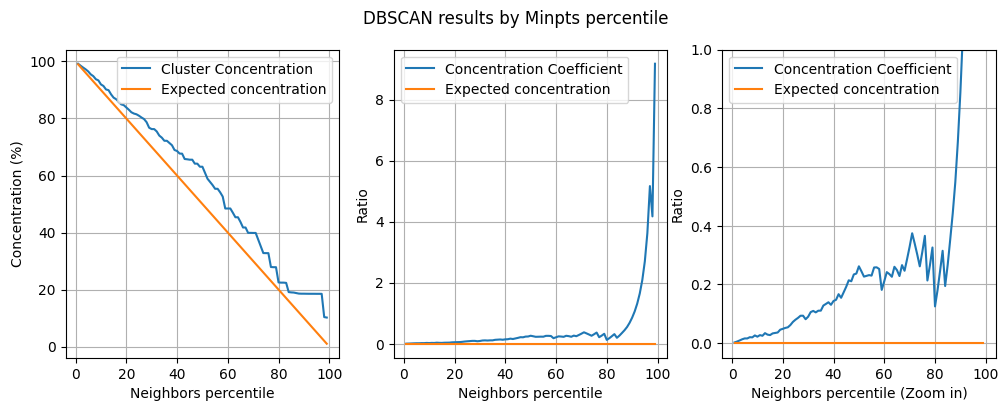

In [106]:
# plot lines
dfplt=df_pctiles[df_pctiles['n_clusters']>0]
plt.figure(figsize=(12, 4))
plt.suptitle('DBSCAN results by Minpts percentile')
plt.subplot(1,3,1)
plt.plot(dfplt['pctile'], dfplt['cluster_share'], label = "Cluster Concentration")
plt.plot(dfplt['pctile'], 100- dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Concentration (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.subplot(1,3,2)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile')
plt.ylabel('Ratio')
plt.legend(loc='upper left')
plt.grid(True)
plt.subplot(1,3,3)
plt.plot(dfplt['pctile'], dfplt['conc_coeff'], label = "Concentration Coefficient")
plt.plot(dfplt['pctile'], dfplt['pctile']-dfplt['pctile'], label = "Expected concentration")
plt.xlabel('Neighbors percentile (Zoom in)')
plt.ylabel('Ratio')
plt.ylim(-0.05, 1)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()